In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from config import PATH, MODEL
from model.Mukara import Mukara
import json

def plot_cluster_assignments(sensor_id, mukara):
    """
    Plot the cluster assignments for origin (O) and destination (D) pixels as a rasterized map,
    zooming into the rectangular area containing the relevant grid cells.

    Args:
        sensor_id (str): Sensor identifier.
        mukara (Mukara): Instance of the Mukara model.
    """
    # Forward pass through the Mukara model to compute cluster assignments
    traffic_volume, (o_indices, d_indices, o_pixel_embeddings, d_pixel_embeddings, o_cluster_embeddings, d_cluster_embeddings, o_cluster_assignments, d_cluster_assignments) = mukara(sensor_id)
    
    # Load grid cells
    from model.dataloader import load_grid_cells
    grid_cells = load_grid_cells()

    # Get the cluster assignments (argmax for hard assignment)
    o_clusters = np.argmax(o_cluster_assignments.numpy(), axis=1)  # (N_o,)
    d_clusters = np.argmax(d_cluster_assignments.numpy(), axis=1)  # (N_d,)
    
    # Assign cluster IDs to the grid cells GeoDataFrame
    grid_cells['o_cluster'] = -1  # Initialize with -1 (no cluster)
    grid_cells['d_cluster'] = -1  # Initialize with -1 (no cluster)
    grid_cells.loc[o_indices, 'o_cluster'] = o_clusters
    grid_cells.loc[d_indices, 'd_cluster'] = d_clusters

    # Extract relevant grid cells for plotting
    o_grid_cells = grid_cells.loc[o_indices]
    d_grid_cells = grid_cells.loc[d_indices]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Origin clusters
    plt.subplot(1, 2, 1)
    # o_grid_cells.boundary.plot(color='gray', linewidth=0.5, ax=plt.gca())  # Plot grid boundaries
    o_grid_cells.plot(column='o_cluster', cmap='tab10', ax=plt.gca(), legend=True)
    plt.title(f"Origin Cluster Assignments (Sensor: {sensor_id})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(o_grid_cells.total_bounds[[0, 2]])  # Zoom to O grid cells
    plt.ylim(o_grid_cells.total_bounds[[1, 3]])  # Zoom to O grid cells
    
    # Destination clusters
    plt.subplot(1, 2, 2)
    # d_grid_cells.boundary.plot(color='gray', linewidth=0.5, ax=plt.gca())  # Plot grid boundaries
    d_grid_cells.plot(column='d_cluster', cmap='tab10', ax=plt.gca(), legend=True)
    plt.title(f"Destination Cluster Assignments (Sensor: {sensor_id})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(d_grid_cells.total_bounds[[0, 2]])  # Zoom to D grid cells
    plt.ylim(d_grid_cells.total_bounds[[1, 3]])  # Zoom to D grid cells
    
    plt.tight_layout()
    plt.show()

In [ ]:
mukara = Mukara()
mukara("2")
mukara.load_weights(os.path.join(PATH['param'], '20250209-185738.h5'))

Grid features shape (653, 573, 14)


(<tf.Tensor: shape=(), dtype=float32, numpy=1.6437662>,
 ([161974,
   162546,
   162547,
   162548,
   163119,
   163120,
   163121,
   163122,
   163123,
   163693,
   163694,
   163695,
   163696,
   163698,
   163716,
   163717,
   164267,
   164268,
   164269,
   164270,
   164271,
   164288,
   164289,
   164290,
   164840,
   164841,
   164842,
   164843,
   164844,
   164851,
   164861,
   164862,
   165412,
   165413,
   165414,
   165415,
   165416,
   165420,
   165421,
   165422,
   165424,
   165426,
   165431,
   165432,
   165433,
   165434,
   165435,
   165987,
   165988,
   165989,
   165990,
   165991,
   165992,
   165993,
   165994,
   165995,
   165997,
   165998,
   165999,
   166000,
   166003,
   166004,
   166005,
   166006,
   166007,
   166008,
   166562,
   166563,
   166564,
   166565,
   166566,
   166567,
   166569,
   166570,
   166571,
   166572,
   166573,
   166574,
   166575,
   166576,
   166577,
   166578,
   166579,
   166580,
   166581,
   166582

In [9]:
mukara.load_weights(os.path.join(PATH['param'], '20250209-220607.h5'))

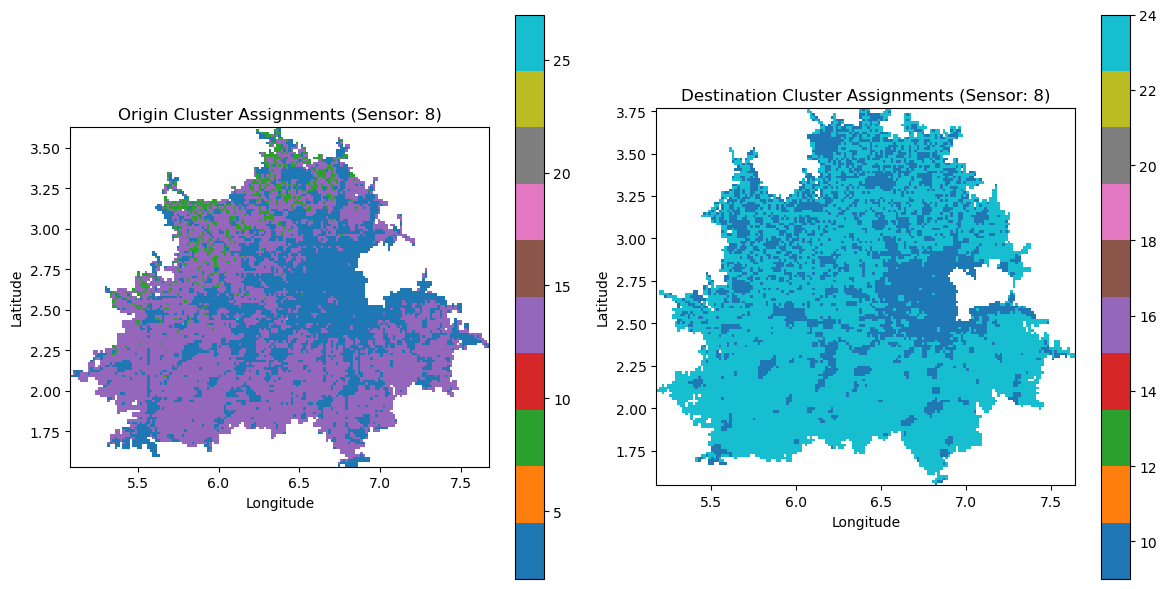

In [10]:
# Plot cluster assignments for the sensor
plot_cluster_assignments("8", mukara)